<a href="https://colab.research.google.com/github/Davioliveira1305/Simulacao-Estocastica/blob/main/Lista4_Simula%C3%A7%C3%A3o_Estoc%C3%A1stica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install simpy

# 1ª Questão

In [2]:
import numpy as np
import simpy
class Reparo:
  def __init__(self, env):
    self.env = env
    self.fila_formacao = simpy.Resource(env, capacity = 1) # Fila de formação eletrolítica
    self.fila_revestimento = simpy.Resource(env, capacity = 1) # Fila de revestimento
    self.fila_reparo = simpy.PriorityResource(env, capacity = 1) # Fila de reparo
    self.tam_fila_reparo = 0
    self.tam_fila_reparo_for = 0 # Tamanho da fila de reparos manuais(formação)
    self.tam_fila_reparo_reves = 0 # Tamanho da fila de reparos manuais(revestimento)
    self.tam_fila_formacao = 0
    self.tam_fila_revestimento = 0
    self.pedidos_no_sistema = 0
    self.tempo_confecc_inicial = [] # Marca o pedido e o tempo que ele começou o processo de confecção
    self.tempo_confecc_final = [] # Marca o pedido e o tempo que ele foi finalizado a sua confecção

  def carga_de_trabalho(self, tam_fila, pedidos_no_sistema):
    return (tam_fila * 100) / pedidos_no_sistema

  def produzir_formacao(self, pedido):
    self.tempo_confecc_inicial.append([pedido, self.env.now])
    self.pedidos_no_sistema = self.pedidos_no_sistema + 1
    self.tam_fila_formacao = self.tam_fila_formacao + 1
    print(f'Pedido {pedido} chegou na fila de formação em {self.env.now}, Tamanho da fila de formação = {self.tam_fila_formacao}, Carga de Trabalho(formação) = {self.carga_de_trabalho(self.tam_fila_formacao, self.pedidos_no_sistema)} %')
    with self.fila_formacao.request() as req:
      yield req
      yield self.env.timeout(np.random.uniform(8, 12))
      self.tam_fila_formacao = self.tam_fila_formacao - 1
      if np.random.rand() < 0.15:
        print(f'Pedido {pedido} precisou de reparo em {self.env.now}, Tamanho da fila de formação = {self.tam_fila_formacao}')
        self.env.process(self.reparo(pedido,'formacao'))
      else:
        print(f'Pedido {pedido} foi para o processo de revestimento em {self.env.now}, Tamanho da fila de formação = {self.tam_fila_formacao}')
        self.env.process(self.revestimento(pedido))

  def revestimento(self, pedido):
    self.tam_fila_revestimento = self.tam_fila_revestimento + 1
    print(f'Pedido {pedido} chegou na fila de revestimento em {self.env.now}, Tamanho da fila de revestimento = {self.tam_fila_revestimento}, Carga de Trabalho(revestimento) = {self.carga_de_trabalho(self.tam_fila_revestimento, self.pedidos_no_sistema)}%')
    with self.fila_revestimento.request() as req:
      yield req
      yield self.env.timeout(np.random.uniform(4, 8))
      self.tam_fila_revestimento = self.tam_fila_revestimento - 1
      if np.random.rand() < 0.12:
        print(f'Pedido {pedido} precisou de reparo em {self.env.now}, Tamanho da fila de revestimento = {self.tam_fila_revestimento}')
        self.env.process(self.reparo(pedido,'revestimento'))

      else:
        self.tempo_confecc_final.append([pedido, self.env.now])
        self.pedidos_no_sistema = self.pedidos_no_sistema - 1
        print(f'Pedido {pedido} ficou pronto em {self.env.now}, Tamanho da fila de revestimento = {self.tam_fila_revestimento}')

  def reparo(self, pedido, tipo):
    self.tam_fila_reparo = self.tam_fila_reparo + 1
    print(f'Pedido {pedido} chegou no reparo em {self.env.now},  Carga de Trabalho(reparo) = {self.carga_de_trabalho(self.tam_fila_reparo, self.pedidos_no_sistema)}%')
    if tipo == 'formacao':
      prio = 0 # Processo de formação tem prioridade na fila de reparos
      self.tam_fila_reparo_for = self.tam_fila_reparo_for + 1
    elif tipo == 'revestimento':
      prio = 1
      self.tam_fila_reparo_reves = self.tam_fila_reparo_reves + 1
    with self.fila_reparo.request(priority = prio) as req:
      yield req
      if tipo == 'formacao':
        yield self.env.timeout(np.random.uniform(10, 20))
        print(f'Pedido {pedido} voltou para o processo de formação em {self.env.now}, Tamanho da fila de reparo(formação) = {self.tam_fila_reparo_for}')
        self.tam_fila_reparo_for = self.tam_fila_reparo_for - 1
        self.tam_fila_reparo = self.tam_fila_reparo - 1
        self.env.process(self.produzir_formacao(pedido))
      else:
        yield self.env.timeout(np.random.uniform(15, 24))
        print(f'Pedido {pedido} voltou para o processo de revestimento em {self.env.now}, Tamanho da fila de reparo(revestimento) = {self.tam_fila_reparo_reves}')
        self.tam_fila_reparo = self.tam_fila_reparo - 1
        self.tam_fila_reparo_reves = self.tam_fila_reparo_reves - 1
        self.env.process(self.revestimento(pedido))

def gera_pedidos(env, reparo):
  pedido = 0
  while True:
    yield env.timeout(np.random.triangular(3,7,14))
    pedido = pedido + 1
    env.process(reparo.produzir_formacao(pedido))

env = simpy.Environment()
fila_reparo = Reparo(env)

env.process(gera_pedidos(env, fila_reparo))

env.run(until=365*24)



Pedido 1 chegou na fila de formação em 3.0323113148048004, Tamanho da fila de formação = 1, Carga de Trabalho(formação) = 100.0 %
Pedido 2 chegou na fila de formação em 10.614896885021503, Tamanho da fila de formação = 2, Carga de Trabalho(formação) = 100.0 %
Pedido 1 foi para o processo de revestimento em 14.62460348822728, Tamanho da fila de formação = 1
Pedido 1 chegou na fila de revestimento em 14.62460348822728, Tamanho da fila de revestimento = 1, Carga de Trabalho(revestimento) = 50.0%
Pedido 3 chegou na fila de formação em 16.272065471918072, Tamanho da fila de formação = 2, Carga de Trabalho(formação) = 66.66666666666667 %
Pedido 1 ficou pronto em 19.762982471728986, Tamanho da fila de revestimento = 0
Pedido 4 chegou na fila de formação em 24.74026848473733, Tamanho da fila de formação = 3, Carga de Trabalho(formação) = 100.0 %
Pedido 2 foi para o processo de revestimento em 25.866965363793817, Tamanho da fila de formação = 2
Pedido 2 chegou na fila de revestimento em 25.8669

In [3]:
vetor_tempos = []
for i in fila_reparo.tempo_confecc_inicial:
  for j in fila_reparo.tempo_confecc_final:
    if i[0] == j[0]:
      vetor_tempos.append(j[1] - i[1])
media = sum(vetor_tempos)/len(vetor_tempos)
print(f'Em média um produto leva {media} horas para ser confeccionado.')

Em média um produto leva 1450.8935726475338 horas para ser confeccionado.


**Como o gargalo estava na fila de formação eletrolítica, adicionei mais uma máquina para essa função.**

In [4]:
import numpy as np
import simpy
class Reparo:
  def __init__(self, env):
    self.env = env
    self.fila_formacao = simpy.Resource(env, capacity = 2) # Fila de formação eletrolítica
    self.fila_revestimento = simpy.Resource(env, capacity = 1) # Fila de revestimento
    self.fila_reparo = simpy.PriorityResource(env, capacity = 1) # Fila de reparo
    self.tam_fila_reparo = 0
    self.tam_fila_reparo_for = 0 # Tamanho da fila de reparos manuais(formação)
    self.tam_fila_reparo_reves = 0 # Tamanho da fila de reparos manuais(revestimento)
    self.tam_fila_formacao = 0
    self.tam_fila_revestimento = 0
    self.pedidos_no_sistema = 0
    self.tempo_confecc_inicial = [] # Marca o pedido e o tempo que ele começou o processo de confecção
    self.tempo_confecc_final = [] # Marca o pedido e o tempo que ele foi finalizado a sua confecção

  def carga_de_trabalho(self, tam_fila, pedidos_no_sistema):
    return (tam_fila * 100) / pedidos_no_sistema

  def produzir_formacao(self, pedido):
    self.tempo_confecc_inicial.append([pedido, self.env.now])
    self.pedidos_no_sistema = self.pedidos_no_sistema + 1
    self.tam_fila_formacao = self.tam_fila_formacao + 1
    print(f'Pedido {pedido} chegou na fila de formação em {self.env.now}, Tamanho da fila de formação = {self.tam_fila_formacao}, Carga de Trabalho(formação) = {self.carga_de_trabalho(self.tam_fila_formacao, self.pedidos_no_sistema)} %')
    with self.fila_formacao.request() as req:
      yield req
      yield self.env.timeout(np.random.uniform(8, 12))
      self.tam_fila_formacao = self.tam_fila_formacao - 1
      if np.random.rand() < 0.15:
        print(f'Pedido {pedido} precisou de reparo em {self.env.now}, Tamanho da fila de formação = {self.tam_fila_formacao}')
        self.env.process(self.reparo(pedido,'formacao'))
      else:
        print(f'Pedido {pedido} foi para o processo de revestimento em {self.env.now}, Tamanho da fila de formação = {self.tam_fila_formacao}')
        self.env.process(self.revestimento(pedido))

  def revestimento(self, pedido):
    self.tam_fila_revestimento = self.tam_fila_revestimento + 1
    print(f'Pedido {pedido} chegou na fila de revestimento em {self.env.now}, Tamanho da fila de revestimento = {self.tam_fila_revestimento}, Carga de Trabalho(revestimento) = {self.carga_de_trabalho(self.tam_fila_revestimento, self.pedidos_no_sistema)}%')
    with self.fila_revestimento.request() as req:
      yield req
      yield self.env.timeout(np.random.uniform(4, 8))
      self.tam_fila_revestimento = self.tam_fila_revestimento - 1
      if np.random.rand() < 0.12:
        print(f'Pedido {pedido} precisou de reparo em {self.env.now}, Tamanho da fila de revestimento = {self.tam_fila_revestimento}')
        self.env.process(self.reparo(pedido,'revestimento'))

      else:
        self.tempo_confecc_final.append([pedido, self.env.now])
        self.pedidos_no_sistema = self.pedidos_no_sistema - 1
        print(f'Pedido {pedido} ficou pronto em {self.env.now}, Tamanho da fila de revestimento = {self.tam_fila_revestimento}')

  def reparo(self, pedido, tipo):
    self.tam_fila_reparo = self.tam_fila_reparo + 1
    print(f'Pedido {pedido} chegou no reparo em {self.env.now},  Carga de Trabalho(reparo) = {self.carga_de_trabalho(self.tam_fila_reparo, self.pedidos_no_sistema)}%')
    if tipo == 'formacao':
      prio = 0 # Processo de formação tem prioridade na fila de reparos
      self.tam_fila_reparo_for = self.tam_fila_reparo_for + 1
    elif tipo == 'revestimento':
      prio = 1
      self.tam_fila_reparo_reves = self.tam_fila_reparo_reves + 1
    with self.fila_reparo.request(priority = prio) as req:
      yield req
      if tipo == 'formacao':
        yield self.env.timeout(np.random.uniform(10, 20))
        print(f'Pedido {pedido} voltou para o processo de formação em {self.env.now}, Tamanho da fila de reparo(formação) = {self.tam_fila_reparo_for}')
        self.tam_fila_reparo_for = self.tam_fila_reparo_for - 1
        self.tam_fila_reparo = self.tam_fila_reparo - 1
        self.env.process(self.produzir_formacao(pedido))
      else:
        yield self.env.timeout(np.random.uniform(15, 24))
        print(f'Pedido {pedido} voltou para o processo de revestimento em {self.env.now}, Tamanho da fila de reparo(revestimento) = {self.tam_fila_reparo_reves}')
        self.tam_fila_reparo = self.tam_fila_reparo - 1
        self.tam_fila_reparo_reves = self.tam_fila_reparo_reves - 1
        self.env.process(self.revestimento(pedido))

def gera_pedidos(env, reparo):
  pedido = 0
  while True:
    yield env.timeout(np.random.triangular(3,7,14))
    pedido = pedido + 1
    env.process(reparo.produzir_formacao(pedido))

env = simpy.Environment()
fila_reparo = Reparo(env)

env.process(gera_pedidos(env, fila_reparo))

env.run(until=365*24)



A saída de streaming foi truncada nas últimas 5000 linhas.
Pedido 124 chegou na fila de revestimento em 1022.3453297129826, Tamanho da fila de revestimento = 1, Carga de Trabalho(revestimento) = 5.2631578947368425%
Pedido 125 chegou na fila de formação em 1023.9357048814928, Tamanho da fila de formação = 1, Carga de Trabalho(formação) = 5.0 %
Pedido 122 voltou para o processo de revestimento em 1029.7430377391356, Tamanho da fila de reparo(revestimento) = 1
Pedido 122 chegou na fila de revestimento em 1029.7430377391356, Tamanho da fila de revestimento = 2, Carga de Trabalho(revestimento) = 10.0%
Pedido 124 ficou pronto em 1030.1918573699825, Tamanho da fila de revestimento = 1
Pedido 126 chegou na fila de formação em 1031.109130463239, Tamanho da fila de formação = 2, Carga de Trabalho(formação) = 10.0 %
Pedido 125 foi para o processo de revestimento em 1032.7255582953944, Tamanho da fila de formação = 1
Pedido 125 chegou na fila de revestimento em 1032.7255582953944, Tamanho da fila 

**Observe que com mais uma máquina para o estágio de formação eletrolítica, o tempo médio de confecção de um produto cai drasticamente.**

In [5]:
vetor_tempos = []
for i in fila_reparo.tempo_confecc_inicial:
  for j in fila_reparo.tempo_confecc_final:
    if i[0] == j[0]:
      vetor_tempos.append(j[1] - i[1])
media = sum(vetor_tempos)/len(vetor_tempos)
print(f'Em média um produto leva {media} horas para ser confeccionado.')

Em média um produto leva 31.254078731006377 horas para ser confeccionado.


# 2ª Questão

In [27]:
global cliente
cliente = 0

class Restaurante:
  def __init__(self, env, at_caixa, at_balcao):
    self.env = env
    self.at_caixa_c = at_caixa # Define a quantidade de atendentes do caixa
    self.at_balcao_b = at_balcao # Define a quantidade de atendentes do balcão
    self.fila_caixa = simpy.Resource(env, capacity = self.at_caixa_c)
    self.fila_balcao = simpy.Resource(env, capacity = self.at_balcao_b)
    self.fila_salao = simpy.Resource(env, capacity = 30)
    self.vetor_fila_caixa = []
    self.vetor_fila_balcao = []
    self.vetor_fila_salao = []
    self.chegadas = 0
    self.saidas = 0
    self.tam_fila_caixa = 0
    self.tam_fila_balcao = 0
    self.tam_fila_salao = 0

  def caixa(self, cliente):
    self.chegadas = self.chegadas + 1
    self.tam_fila_caixa = self.tam_fila_caixa + 1
    print(f'cliente {cliente} chegou no caixa em {self.env.now}, Tamanho da fila do caixa = {self.tam_fila_caixa}')
    self.vetor_fila_caixa.append(self.tam_fila_caixa)
    with self.fila_caixa.request() as req:
      yield req
      yield self.env.timeout(0.5)
      self.env.process(self.pedido(cliente))

  def pedido(self, cliente):
    yield self.env.timeout(np.random.triangular(1,2,4))
    print(f'O pedido do cliente {cliente} foi agendado em {self.env.now}')
    self.env.process(self.pagamento(cliente))

  def pagamento(self, cliente):
    yield self.env.timeout(np.random.triangular(1,2,3))
    print(f'O cliente {cliente} pagou em {self.env.now}')
    self.tam_fila_caixa = self.tam_fila_caixa - 1
    yield self.env.timeout(0.5)
    self.env.process(self.balcao(cliente))

  def balcao(self, cliente):
    self.tam_fila_balcao = self.tam_fila_balcao + 1
    print(f'O cliente {cliente} chegou no balcão em {self.env.now}, Tamanho da fila balcão = {self.tam_fila_balcao}')
    self.vetor_fila_balcao.append(self.tam_fila_balcao)
    with self.fila_balcao.request() as req:
      yield req
      yield self.env.timeout(np.random.uniform(0.5, 2))
      self.tam_fila_balcao = self.tam_fila_balcao - 1
      self.env.process(self.salao(cliente))

  def salao(self, cliente):
    yield self.env.timeout(0.5)
    self.tam_fila_salao = self.tam_fila_salao + 1
    print(f'O cliente {cliente} sentou em um lugar em {self.env.now}, Tamanho da fila salão = {self.tam_fila_salao}')
    self.vetor_fila_salao.append(self.tam_fila_salao)
    with self.fila_salao.request() as req:
      yield req
      yield self.env.timeout(np.random.triangular(10, 20, 30))
      print(f'O cliente {cliente} foi embora em {self.env.now}')
      self.saidas = self.saidas + 1
      self.tam_fila_salao = self.tam_fila_salao - 1

def gera_pe(env, restau, cliente):
  while True:
      if env.now >= 60 and env.now <= 180:
        restau.at_caixa = 9
        restau.at_balcao = 3
      yield env.timeout(np.random.exponential(3))
      cliente = cliente + 1
      env.process(restau.caixa(cliente))

def gera_carro(env, restau, cliente):
    while True:
      if env.now >= 60 and env.now <= 180:
        restau.at_caixa = 9
        restau.at_balcao = 3
      u = np.random.rand()
      if u <= 0.4: qtd = 2
      elif u > 0.4 and u <= 0.6: qtd = 3
      elif u > 0.6 and u <= 0.9: qtd = 4
      elif u > 0.9 and u <= 1: qtd = 5
      yield env.timeout(np.random.exponential(5))
      for i in range(qtd):
          cliente = cliente + 1
          env.process(restau.caixa(cliente))

def gera_onibus(env, restau, cliente):
      if env.now >= 60 and env.now <= 180:
        restau.at_caixa = 9
        restau.at_balcao = 3
      u = np.random.uniform(60, 180) # Tempo em que o ônibus chega
      yield env.timeout(u)
      qtd = np.random.poisson(30) # Quantidade de pessoas do ônibus
      for i in range(qtd):
        cliente = cliente + 1
        env.process(restau.caixa(cliente))

def agendar_descanso(env, restau):
  while True:
    u = np.random.rand() # Se u <= 0.5 será agendado um descanso
    if u <= 0.5:
      lugar = np.random.choice(['C', 'B']) # Sorteio para saber se o descanso será para um funcionário do caixa ou do balcão
      if lugar == 'C':
        restau.at_caixa_c = restau.at_caixa_c - 1
      else:
        restau.at_balcao_b = restau.at_balcao_b - 1
    yield env.timeout(10)
    if lugar == 'C': restau.at_caixa_c = restau.at_caixa_c + 1
    else: restau.at_balcao_b = restau.at_balcao_b + 1

env = simpy.Environment()
restau = Restaurante(env, 3, 1)

env.process(gera_pe(env,restau, cliente))
env.process(gera_onibus(env,restau, cliente))
env.process(gera_carro(env, restau, cliente))

env.run(until=240)

cliente 1 chegou no caixa em 0.7655438018773307, Tamanho da fila do caixa = 1
cliente 2 chegou no caixa em 0.7655438018773307, Tamanho da fila do caixa = 2
cliente 3 chegou no caixa em 0.7655438018773307, Tamanho da fila do caixa = 3
cliente 4 chegou no caixa em 0.7655438018773307, Tamanho da fila do caixa = 4
O pedido do cliente 4 foi agendado em 3.146534375623072
cliente 5 chegou no caixa em 3.787628006534683, Tamanho da fila do caixa = 5
cliente 6 chegou no caixa em 3.787628006534683, Tamanho da fila do caixa = 6
cliente 7 chegou no caixa em 3.787628006534683, Tamanho da fila do caixa = 7
O pedido do cliente 1 foi agendado em 3.998570565251846
O pedido do cliente 2 foi agendado em 4.331628306628586
cliente 1 chegou no caixa em 4.4422377459084235, Tamanho da fila do caixa = 8
O pedido do cliente 3 foi agendado em 4.819797884355619
O cliente 1 pagou em 5.3369177145032936
O cliente 4 pagou em 5.588147498317385
cliente 2 chegou no caixa em 5.738972638265103, Tamanho da fila do caixa = 7

## Estatísticas das filas do restaurante

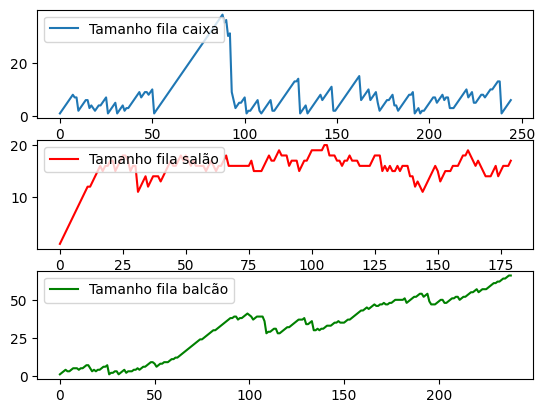

In [28]:
import matplotlib.pyplot as plt
fig, aux = plt.subplots(nrows = 3)
eixo_x_c = [i for i in range(len(restau.vetor_fila_caixa))]
aux[0].plot(eixo_x_c, restau.vetor_fila_caixa, label = 'Tamanho fila caixa')
aux[0].legend(loc = 'upper left')
eixo_x_s = [i for i in range(len(restau.vetor_fila_salao))]
aux[1].plot(eixo_x_s, restau.vetor_fila_salao, c = 'r', label = 'Tamanho fila salão')
aux[1].legend(loc = 'upper left')
eixo_x_b = [i for i in range(len(restau.vetor_fila_balcao))]
aux[2].plot(eixo_x_b, restau.vetor_fila_balcao, c = 'g', label = 'Tamanho fila balcão')
aux[2].legend(loc = 'upper left')
plt.show()

In [29]:
print(f'Foram atendidas completamente {restau.saidas} pessoas de {restau.chegadas}')

Foram atendidas completamente 164 pessoas de 245


**Como o observado nos gráficos, está tendo um gargalo na fila do balcão, meu conselho seria designar contratar mais atendentes para o balcão**

---



In [31]:
global cliente_1
cliente_1 = 0

class Restaurante:
  def __init__(self, env, at_caixa, at_balcao):
    self.env = env
    self.at_caixa_c = at_caixa # Define a quantidade de atendentes do caixa
    self.at_balcao_b = at_balcao # Define a quantidade de atendentes do balcão
    self.fila_caixa = simpy.Resource(env, capacity = self.at_caixa_c)
    self.fila_balcao = simpy.Resource(env, capacity = self.at_balcao_b)
    self.fila_salao = simpy.Resource(env, capacity = 30)
    self.vetor_fila_caixa = []
    self.vetor_fila_balcao = []
    self.vetor_fila_salao = []
    self.chegadas = 0
    self.saidas = 0
    self.tam_fila_caixa = 0
    self.tam_fila_balcao = 0
    self.tam_fila_salao = 0

  def caixa(self, cliente_1):
    self.chegadas = self.chegadas + 1
    self.tam_fila_caixa = self.tam_fila_caixa + 1
    print(f'cliente {cliente_1} chegou no caixa em {self.env.now}, Tamanho da fila do caixa = {self.tam_fila_caixa}')
    self.vetor_fila_caixa.append(self.tam_fila_caixa)
    with self.fila_caixa.request() as req:
      yield req
      yield self.env.timeout(0.5)
      self.env.process(self.pedido(cliente_1))

  def pedido(self, cliente_1):
    yield self.env.timeout(np.random.triangular(1,2,4))
    print(f'O pedido do cliente {cliente_1} foi agendado em {self.env.now}')
    self.env.process(self.pagamento(cliente_1))

  def pagamento(self, cliente_1):
    yield self.env.timeout(np.random.triangular(1,2,3))
    print(f'O cliente {cliente_1} pagou em {self.env.now}')
    self.tam_fila_caixa = self.tam_fila_caixa - 1
    yield self.env.timeout(0.5)
    self.env.process(self.balcao(cliente_1))

  def balcao(self, cliente_1):
    self.tam_fila_balcao = self.tam_fila_balcao + 1
    print(f'O cliente {cliente_1} chegou no balcão em {self.env.now}, Tamanho da fila balcão = {self.tam_fila_balcao}')
    self.vetor_fila_balcao.append(self.tam_fila_balcao)
    with self.fila_balcao.request() as req:
      yield req
      yield self.env.timeout(np.random.uniform(0.5, 2))
      self.tam_fila_balcao = self.tam_fila_balcao - 1
      self.env.process(self.salao(cliente_1))

  def salao(self, cliente_1):
    yield self.env.timeout(0.5)
    self.tam_fila_salao = self.tam_fila_salao + 1
    print(f'O cliente {cliente_1} sentou em um lugar em {self.env.now}, Tamanho da fila salão = {self.tam_fila_salao}')
    self.vetor_fila_salao.append(self.tam_fila_salao)
    with self.fila_salao.request() as req:
      yield req
      yield self.env.timeout(np.random.triangular(10, 20, 30))
      print(f'O cliente {cliente_1} foi embora em {self.env.now}')
      self.saidas = self.saidas + 1
      self.tam_fila_salao = self.tam_fila_salao - 1

def gera_pe(env, restau, cliente_1):
  while True:
      if env.now >= 60 and env.now <= 180:
        restau.at_caixa = 9
        restau.at_balcao = 6
      yield env.timeout(np.random.exponential(3))
      cliente_1 = cliente_1 + 1
      env.process(restau.caixa(cliente_1))

def gera_carro(env, restau, cliente_1):
    while True:
      if env.now >= 60 and env.now <= 180:
        restau.at_caixa = 9
        restau.at_balcao = 3
      u = np.random.rand()
      if u <= 0.4: qtd = 2
      elif u > 0.4 and u <= 0.6: qtd = 3
      elif u > 0.6 and u <= 0.9: qtd = 4
      elif u > 0.9 and u <= 1: qtd = 5
      yield env.timeout(np.random.exponential(5))
      for i in range(qtd):
          cliente_1 = cliente_1 + 1
          env.process(restau.caixa(cliente_1))

def gera_onibus(env, restau, cliente_1):
      if env.now >= 60 and env.now <= 180:
        restau.at_caixa = 9
        restau.at_balcao = 3
      u = np.random.uniform(60, 180) # Tempo em que o ônibus chega
      yield env.timeout(u)
      qtd = np.random.poisson(30) # Quantidade de pessoas do ônibus
      for i in range(qtd):
        cliente_1 = cliente_1 + 1
        env.process(restau.caixa(cliente_1))

def agendar_descanso(env, restau):
  while True:
    u = np.random.rand() # Se u <= 0.5 será agendado um descanso
    if u <= 0.5:
      lugar = np.random.choice(['C', 'B']) # Sorteio para saber se o descanso será para um funcionário do caixa ou do balcão
      if lugar == 'C':
        restau.at_caixa_c = restau.at_caixa_c - 1
      else:
        restau.at_balcao_b = restau.at_balcao_b - 1
    yield env.timeout(10)
    if lugar == 'C': restau.at_caixa_c = restau.at_caixa_c + 1
    else: restau.at_balcao_b = restau.at_balcao_b + 1

env = simpy.Environment()
restau = Restaurante(env, 3, 3)

env.process(gera_pe(env,restau, cliente_1))
env.process(gera_onibus(env,restau, cliente_1))
env.process(gera_carro(env, restau, cliente_1))

env.run(until=240)

cliente 1 chegou no caixa em 2.042091373594614, Tamanho da fila do caixa = 1
cliente 2 chegou no caixa em 2.042091373594614, Tamanho da fila do caixa = 2
cliente 1 chegou no caixa em 3.13257161949205, Tamanho da fila do caixa = 3
cliente 3 chegou no caixa em 3.400920111433656, Tamanho da fila do caixa = 4
cliente 4 chegou no caixa em 3.400920111433656, Tamanho da fila do caixa = 5
cliente 5 chegou no caixa em 3.400920111433656, Tamanho da fila do caixa = 6
cliente 6 chegou no caixa em 3.400920111433656, Tamanho da fila do caixa = 7
cliente 7 chegou no caixa em 3.400920111433656, Tamanho da fila do caixa = 8
O pedido do cliente 2 foi agendado em 4.774077990225531
O pedido do cliente 1 foi agendado em 5.188706816980674
O pedido do cliente 7 foi agendado em 5.543812953344139
O pedido do cliente 4 foi agendado em 5.7743965726358955
O pedido do cliente 6 foi agendado em 5.877939622443878
O pedido do cliente 3 foi agendado em 6.012524739711441
O cliente 2 pagou em 6.085018674724315
O pedido 

**Observe que, com a contratação de 3 atendentes para o balcão as filas já dão uma estabilizada**

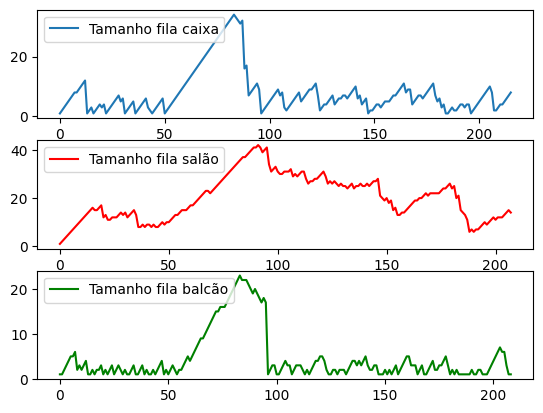

In [32]:
import matplotlib.pyplot as plt
fig, aux = plt.subplots(nrows = 3)
eixo_x_c = [i for i in range(len(restau.vetor_fila_caixa))]
aux[0].plot(eixo_x_c, restau.vetor_fila_caixa, label = 'Tamanho fila caixa')
aux[0].legend(loc = 'upper left')
eixo_x_s = [i for i in range(len(restau.vetor_fila_salao))]
aux[1].plot(eixo_x_s, restau.vetor_fila_salao, c = 'r', label = 'Tamanho fila salão')
aux[1].legend(loc = 'upper left')
eixo_x_b = [i for i in range(len(restau.vetor_fila_balcao))]
aux[2].plot(eixo_x_b, restau.vetor_fila_balcao, c = 'g', label = 'Tamanho fila balcão')
aux[2].legend(loc = 'upper left')
plt.show()

**Note que mais pessoas foram atendidas por completo no restaurante até as 14hrs(240), observe que no salão também tá tendo muito pessoas esperando uma mesa livre, outra dica seria comprar mais lugares no salão.**

In [33]:
print(f'Foram atendidas completamente {restau.saidas} pessoas de {restau.chegadas}')

Foram atendidas completamente 194 pessoas de 216
